# MIS Project - Are US car manufacturers dying?



### Shahmir Javed, Gabriel Kinshuk, Zan Merrill, Aubrey Oh, Bhagya Puppala

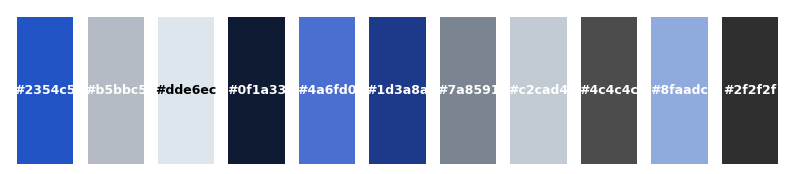

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices

# Define custom colors
custom_colors = [
    "#2354c5",  # Primary blue
    "#b5bbc5",  # Light grey
    "#dde6ec",  # Lighter grey/blue
    "#0f1a33",  # Very Dark Blue
    "#4a6fd0",  # Complementary lighter blue
    "#1d3a8a",  # Deep navy blue
    "#7a8591",  # Medium grey
    "#c2cad4",  # Soft blue-grey
    "#4c4c4c",  # Charcoal grey
    "#8faadc",  # Pastel blue
    "#2f2f2f"    # Dark Warm Grey
]

# --- Set for Matplotlib ---
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# --- Set for Seaborn ---
sns.set_palette(custom_colors)


# --- Color Pallette Visualization ---
# Create a bar chart as a palette
fig, ax = plt.subplots(figsize=(10, 2))
ax.bar(range(len(custom_colors)), [1]*len(custom_colors), color=custom_colors)

# Add hex codes on each bar
for i, color in enumerate(custom_colors):
    ax.text(i, 0.5, color, ha='center', va='center',
            color='white' if i != 2 else 'black', fontsize=9, fontweight='bold')

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-0.5, len(custom_colors)-0.5)
ax.axis('off')

plt.show()



In [3]:
cars_data = pd.read_csv("car_prices.csv")

### Removing columns not related to our analysis: vin, trim, seller, saledate  

In [4]:
cars_data = cars_data.drop(columns=['vin', 'seller', 'saledate', 'trim'])

cars_data

,year,make,model,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice
0,2015,Kia,Sorento,SUV,automatic,ca,5.0,16639.0,white,black,20500.0,21500.0
1,2015,Kia,Sorento,SUV,automatic,ca,5.0,9393.0,white,beige,20800.0,21500.0
2,2014,BMW,3 Series,Sedan,automatic,ca,45.0,1331.0,gray,black,31900.0,30000.0
3,2015,Volvo,S60,Sedan,automatic,ca,41.0,14282.0,white,black,27500.0,27750.0
4,2014,BMW,6 Series Gran Coupe,Sedan,automatic,ca,43.0,2641.0,gray,black,66000.0,67000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
558832,2015,Kia,K900,Sedan,NaN,in,45.0,18255.0,silver,black,35300.0,33000.0
558833,2012,Ram,2500,Crew Cab,automatic,wa,5.0,54393.0,white,black,30200.0,30800.0
558834,2012,BMW,X5,SUV,automatic,ca,48.0,50561.0,black,black,29800.0,34000.0
558835,2015,Nissan,Altima,sedan,automatic,ga,38.0,16658.0,white,black,15100.0,11100.0


In [5]:
make_to_country = {
    'kia': 'South Korea', 'bmw': 'Germany', 'volvo': 'Sweden', 'nissan': 'Japan', 'chevrolet': 'USA', 'audi': 'Germany', 'ford': 'USA', 'hyundai': 'South Korea', 'buick': 'USA', 'cadillac': 'USA', 'acura': 'Japan', 'lexus': 'Japan', 'infiniti': 'Japan', 'jeep': 'USA', 'mercedes-benz': 'Germany', 'mercedes': 'Germany', 'mitsubishi': 'Japan', 'mazda': 'Japan', 'mini': 'UK', 'land rover': 'UK', 'landrover': 'UK', 'lincoln': 'USA', 'jaguar': 'UK', 
    'volkswagen': 'Germany', 'vw': 'Germany', 'toyota': 'Japan', 'subaru': 'Japan', 'scion': 'Japan', 'porsche': 'Germany', 'dodge': 'USA', 'fiat': 'Italy', 'chrysler': 'USA', 'ferrari': 'Italy', 'honda': 'Japan', 'gmc': 'USA', 'gmc truck': 'USA', 'ram': 'USA', 'smart': 'Germany', 'bentley': 'UK', 'pontiac': 'USA', 'saturn': 'USA', 'maserati': 'Italy', 'mercury': 'USA', 'hummer': 'USA', 'saab': 'Sweden', 'suzuki': 'Japan', 'oldsmobile': 'USA', 'isuzu': 'Japan', 'dodge tk': 'USA', 'geo': 'USA', 'rolls-royce': 'UK', 
    'tesla': 'USA', 'airstream': 'USA', 'dot': 'Unknown', 'aston martin': 'UK', 'fisker': 'USA', 'lamborghini': 'Italy', 'lotus': 'UK', 'mazda tk': 'Japan', 'mercedes-b': 'Germany', 'chev truck': 'USA', 'ford tk': 'USA', 'plymouth': 'USA', 'ford truck': 'USA', 'hyundai tk': 'South Korea', 'chrysler': 'USA'
}


luxury_makes = {
    'acura', 'audi', 'bmw', 'cadillac', 'infiniti', 'jaguar', 'land rover',
    'lexus', 'lincoln', 'mercedes-benz', 'mercedes', 'porsche', 'volvo',
    'tesla', 'bentley', 'rolls-royce', 'maserati', 'ferrari', 'aston martin',
    'lamborghini', 'lotus'
}


# Add country column
cars_data['manufacturer_country'] = (
    cars_data['make']
    .str.lower()
    .str.strip()
    .map(make_to_country)
    .fillna('Unknown')
)

# Add luxury or standard
cars_data['luxury_or_standard'] = (
    cars_data['make']
    .str.lower()
    .str.strip()
    .isin(luxury_makes)
    .map({True: 'Luxury', False: 'Standard'})
)



### Remove rows with bad data

In [6]:
# Remove rows with invalid state and invalid color
cars_data = cars_data[~cars_data["state"].str.startswith('3')].reset_index(drop=True)

cars_data = cars_data.dropna(subset=['color'])
cars_data = cars_data[~cars_data["color"].str.match(r'^\d')].reset_index(drop=True)

### Save final data set

In [7]:
cars_data.to_csv('car_data.csv', index=False)

### Plot each numeric feature as a histogram and each categorical feature as a barplot. Only showed models with counts > 1000

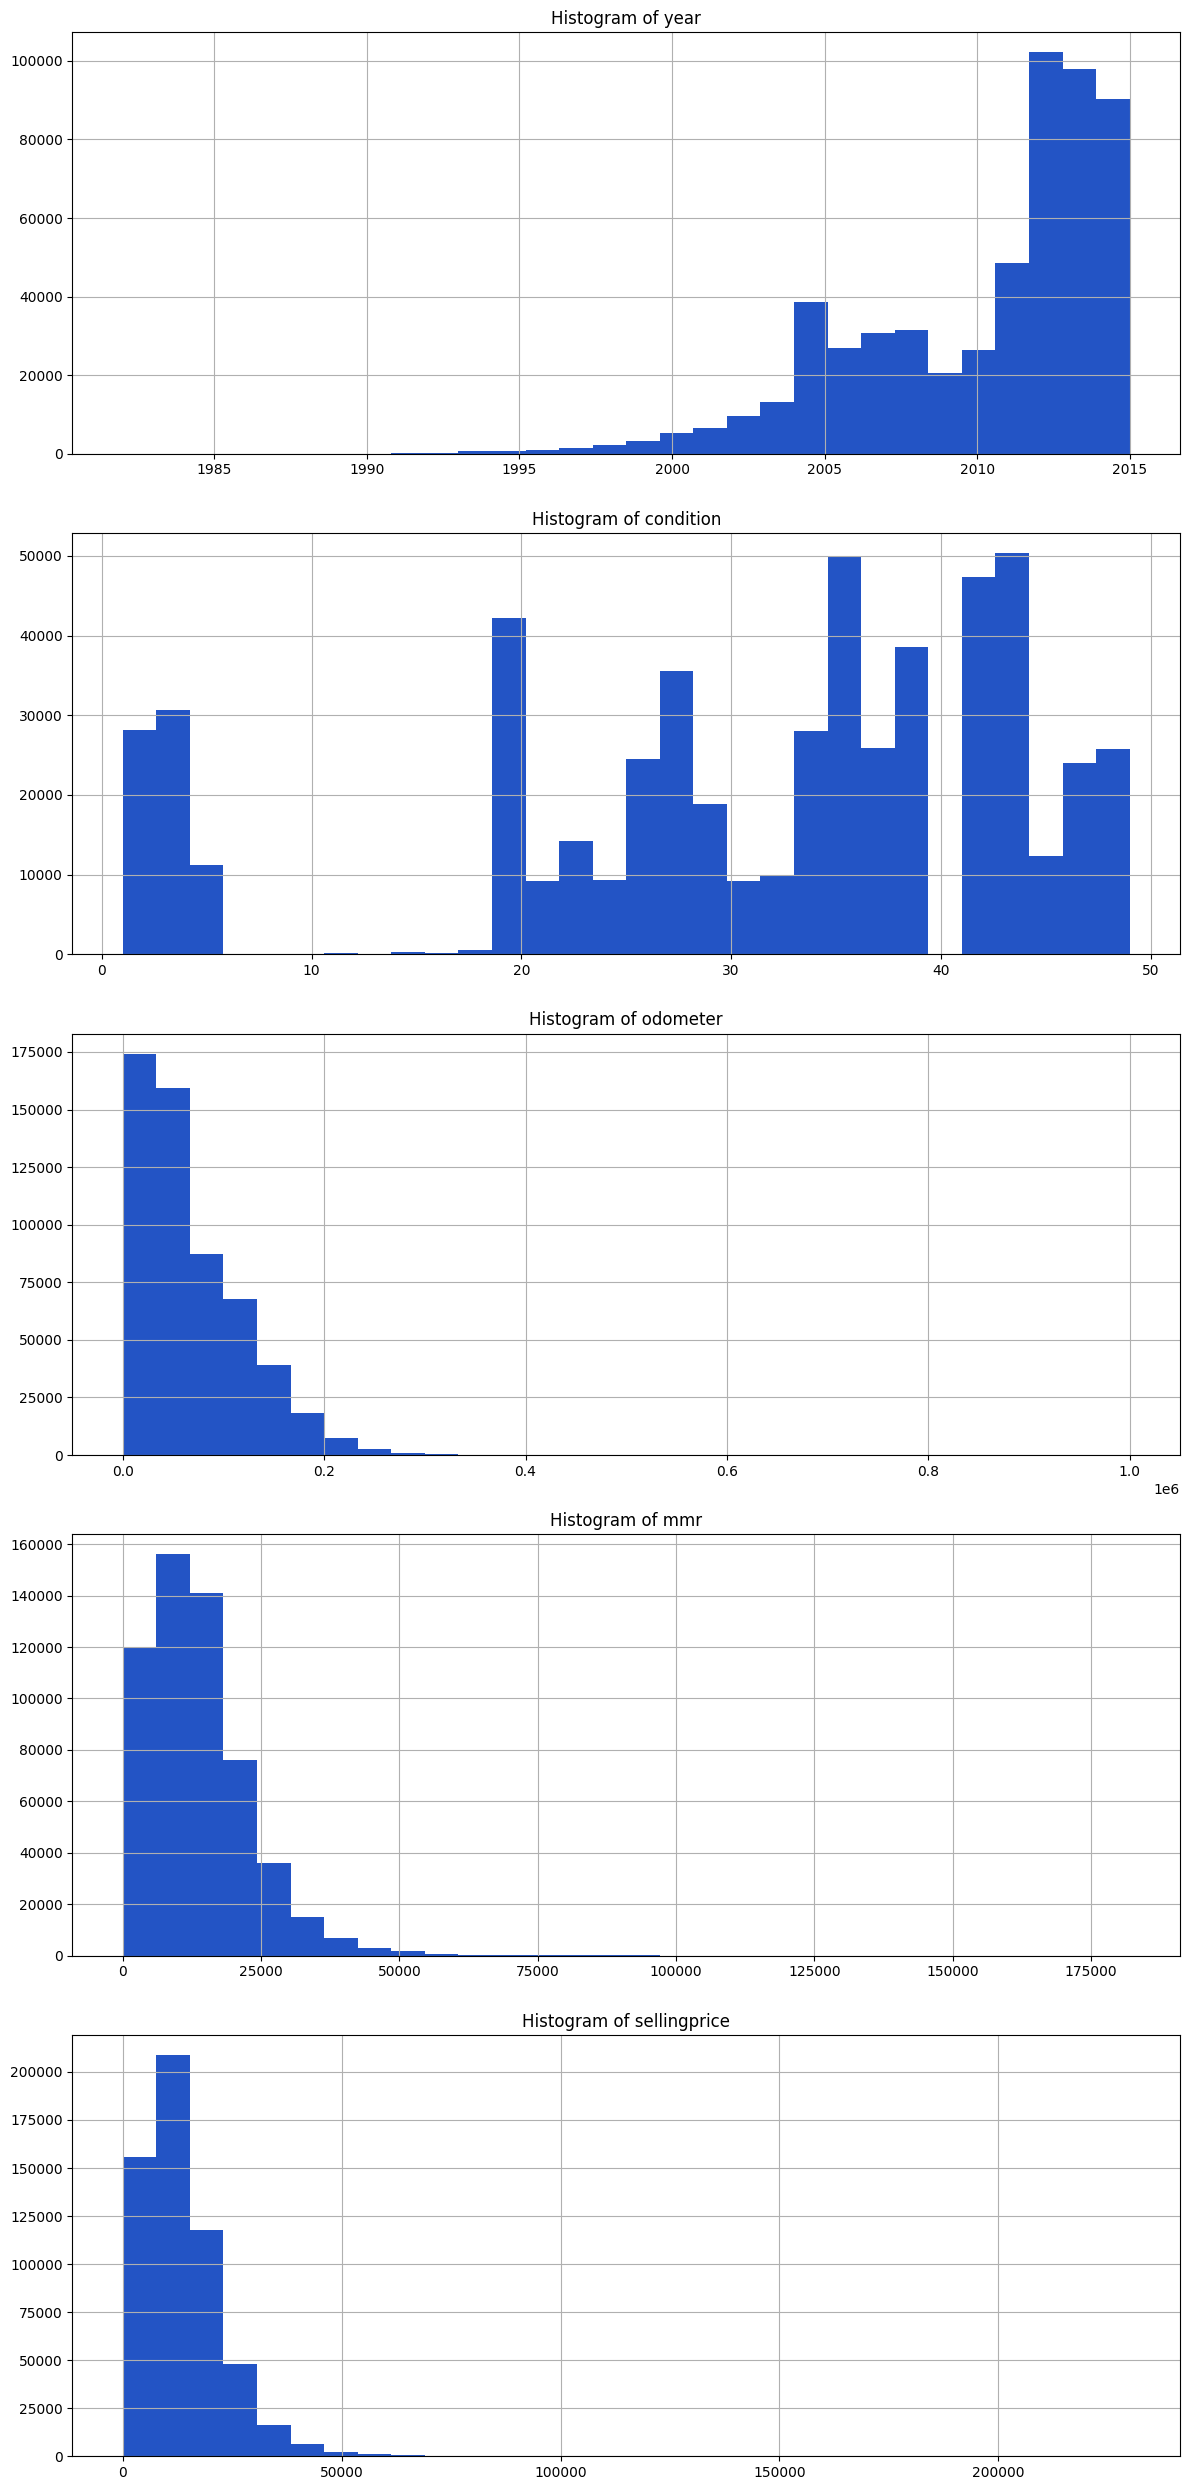

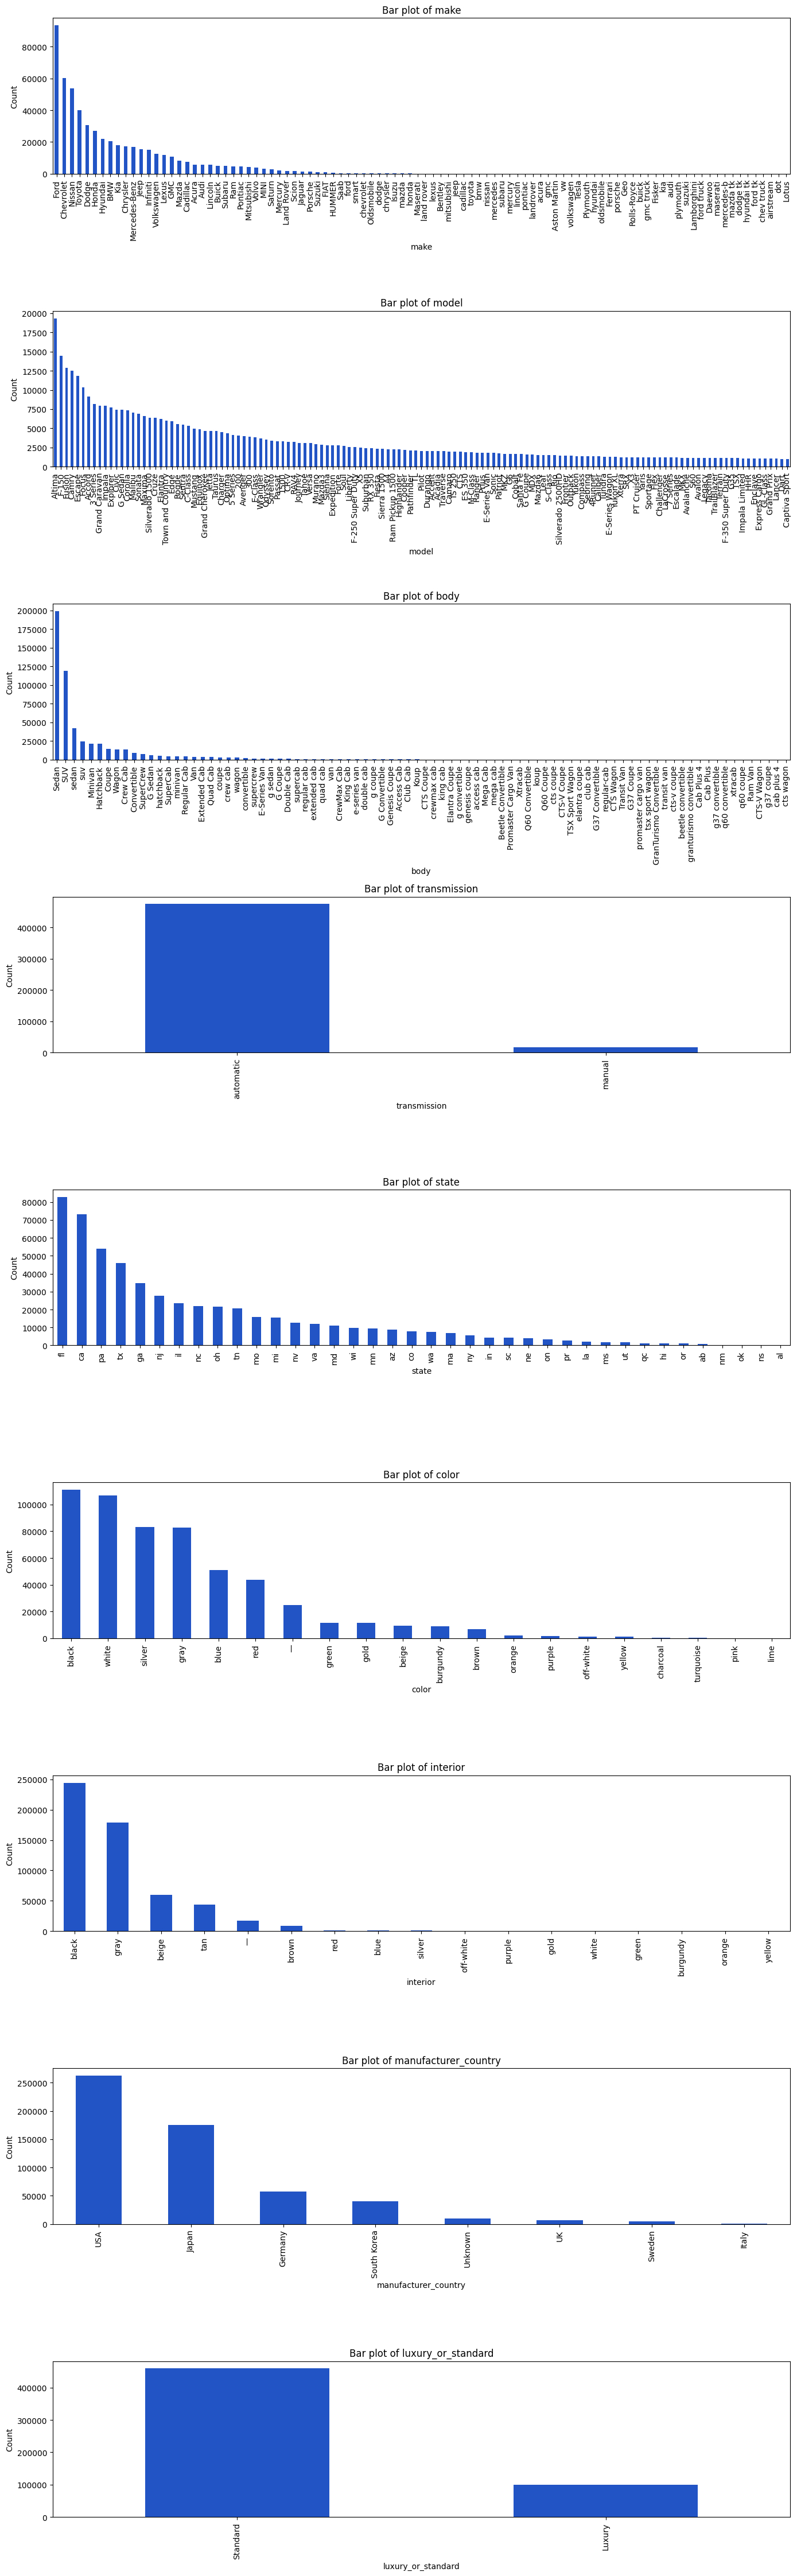

In [8]:
import matplotlib.pyplot as plt

# Numeric columns to histogram
numeric_cols = ['year', 'condition', 'odometer', 'mmr', 'sellingprice']

# Categorical columns to bar plot (all columns except numeric)
categorical_cols = [col for col in cars_data.columns if col not in numeric_cols]

# Plot histograms for numeric columns with wider figures
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(12, 5 * len(numeric_cols)))
for i, col in enumerate(numeric_cols):
    ax = axes[i] if len(numeric_cols) > 1 else axes
    cars_data[col].hist(bins=30, ax=ax)
    ax.set_title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

# Plot bar plots for categorical columns with wider figures
fig, axes = plt.subplots(len(categorical_cols), 1, figsize=(14, 5 * len(categorical_cols)))
for i, col in enumerate(categorical_cols):
    ax = axes[i] if len(categorical_cols) > 1 else axes
    if col == 'model':
        # Only plot models with counts > 1000
        counts = cars_data[col].value_counts()
        counts = counts[counts > 1000]
        counts.plot(kind='bar', ax=ax)
    else:
        cars_data[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f'Bar plot of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()


In [9]:
cars_data.columns.values

array(['year', 'make', 'model', 'body', 'transmission', 'state',
       'condition', 'odometer', 'color', 'interior', 'mmr',
       'sellingprice', 'manufacturer_country', 'luxury_or_standard'],
      dtype=object)

In [10]:
avg_price_per_country = cars_data.groupby('manufacturer_country')['sellingprice'].mean().sort_values(ascending=False)
avg_price_per_country

manufacturer_country
UK             20848.860284
Germany        18973.977884
Italy          17527.516602
USA            13192.366034
Japan          12985.949204
South Korea    11366.877575
Sweden         10567.339273
Unknown         8964.740816
Name: sellingprice, dtype: float64

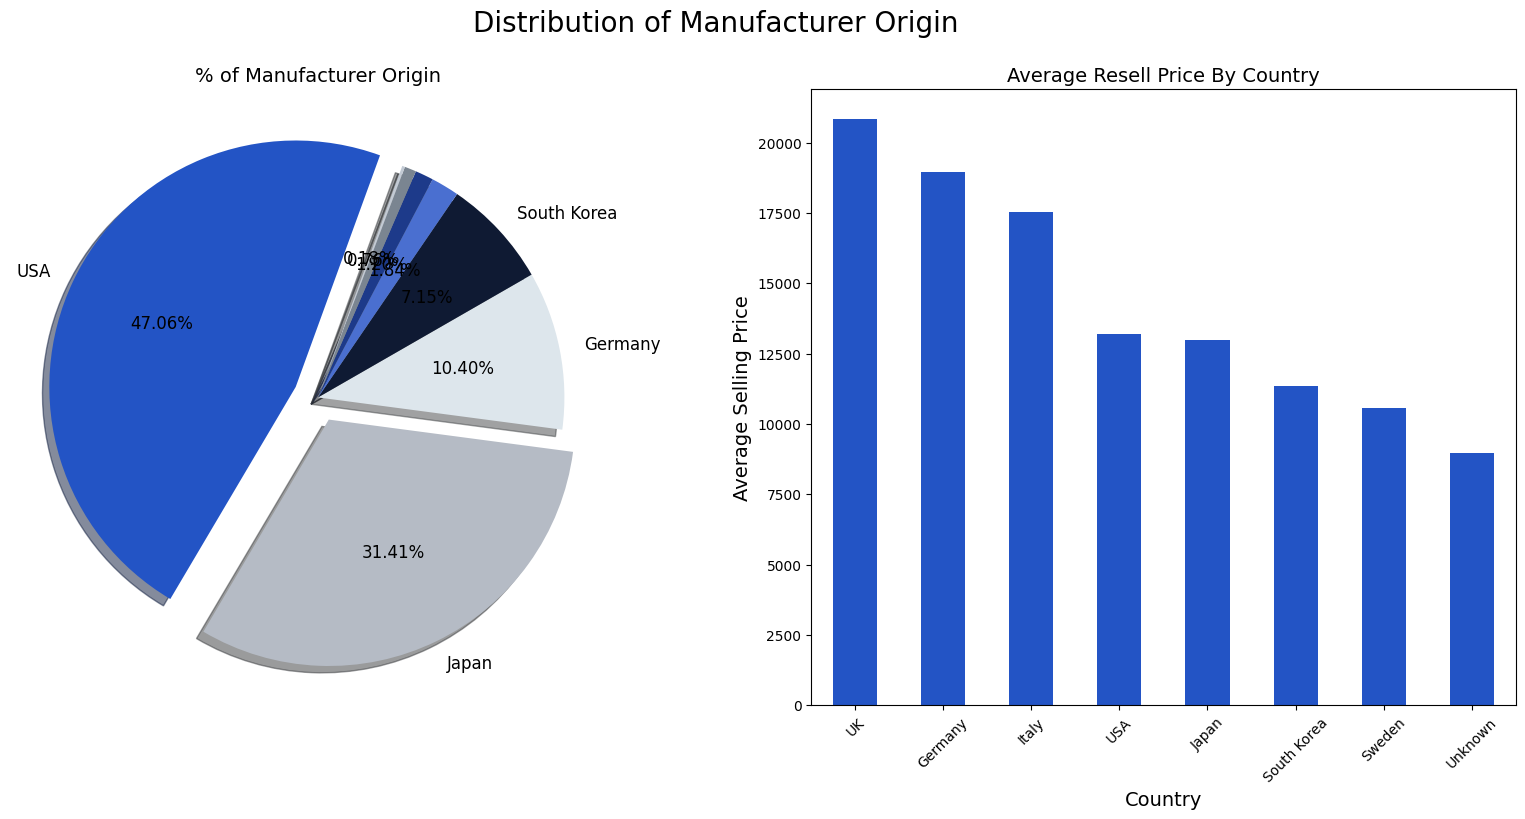

In [11]:
#Manufacturer distribution
f, ax = plt.subplots(1,2, figsize=(20,8))

labels = ['USA', 'Japan', 'Germany', 'South Korea', '', '', '', '']

plt.suptitle('Distribution of Manufacturer Origin', fontsize=20)

cars_data['manufacturer_country'].value_counts().plot.pie(explode=[0.1,0.1,0,0,0,0,0,0], autopct='%1.2f%%', 
                                                 pctdistance=0.6, labeldistance=1.1, ax=ax[0], shadow=True,
                                                 labels=labels, fontsize=12, startangle=70)

ax[0].set_title('% of Manufacturer Origin', fontsize=14)
ax[0].set_ylabel('', fontsize=14)

avg_price_per_country.plot(kind='bar', ax=ax[1])

ax[1].set_title('Average Resell Price By Country', fontsize=14)
ax[1].set_xlabel('Country', fontsize=14)
ax[1].set_ylabel('Average Selling Price', fontsize=14)
ax[1].tick_params(axis='x', rotation=45)

Seems like EU cars have more resell value, despite their lower amount of resales

Text(0, 0.5, '')

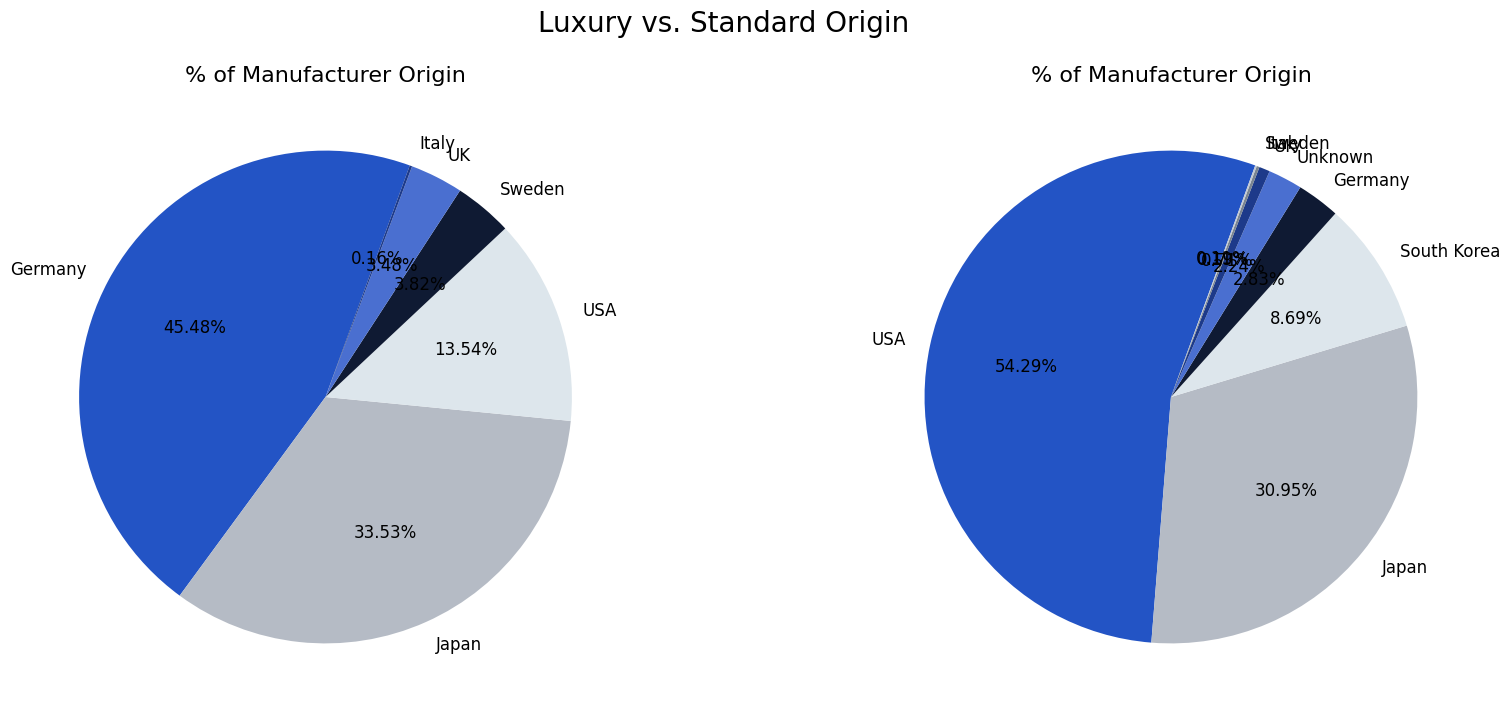

In [12]:
f, ax = plt.subplots(1,2, figsize=(20,8))

plt.suptitle('Luxury vs. Standard Origin', fontsize=20)

cars_data[cars_data['luxury_or_standard'] == 'Luxury']['manufacturer_country'].value_counts().sort_values(ascending=False).plot.pie(autopct='%1.2f%%', 
                                                 pctdistance=0.6, labeldistance=1.1, ax=ax[0],
                                                 fontsize=12, startangle=70)

ax[0].set_title('% of Manufacturer Origin', fontsize=16)
ax[0].set_ylabel('', fontsize=16)

cars_data[cars_data['luxury_or_standard'] == 'Standard']['manufacturer_country'].value_counts().sort_values(ascending=False).plot.pie(autopct='%1.2f%%', 
                                                 pctdistance=0.6, labeldistance=1.1, ax=ax[1],
                                                 fontsize=12, startangle=70)

ax[1].set_title('% of Manufacturer Origin', fontsize=16)
ax[1].set_ylabel('', fontsize=16)


A lot more standard cars, but by how much?

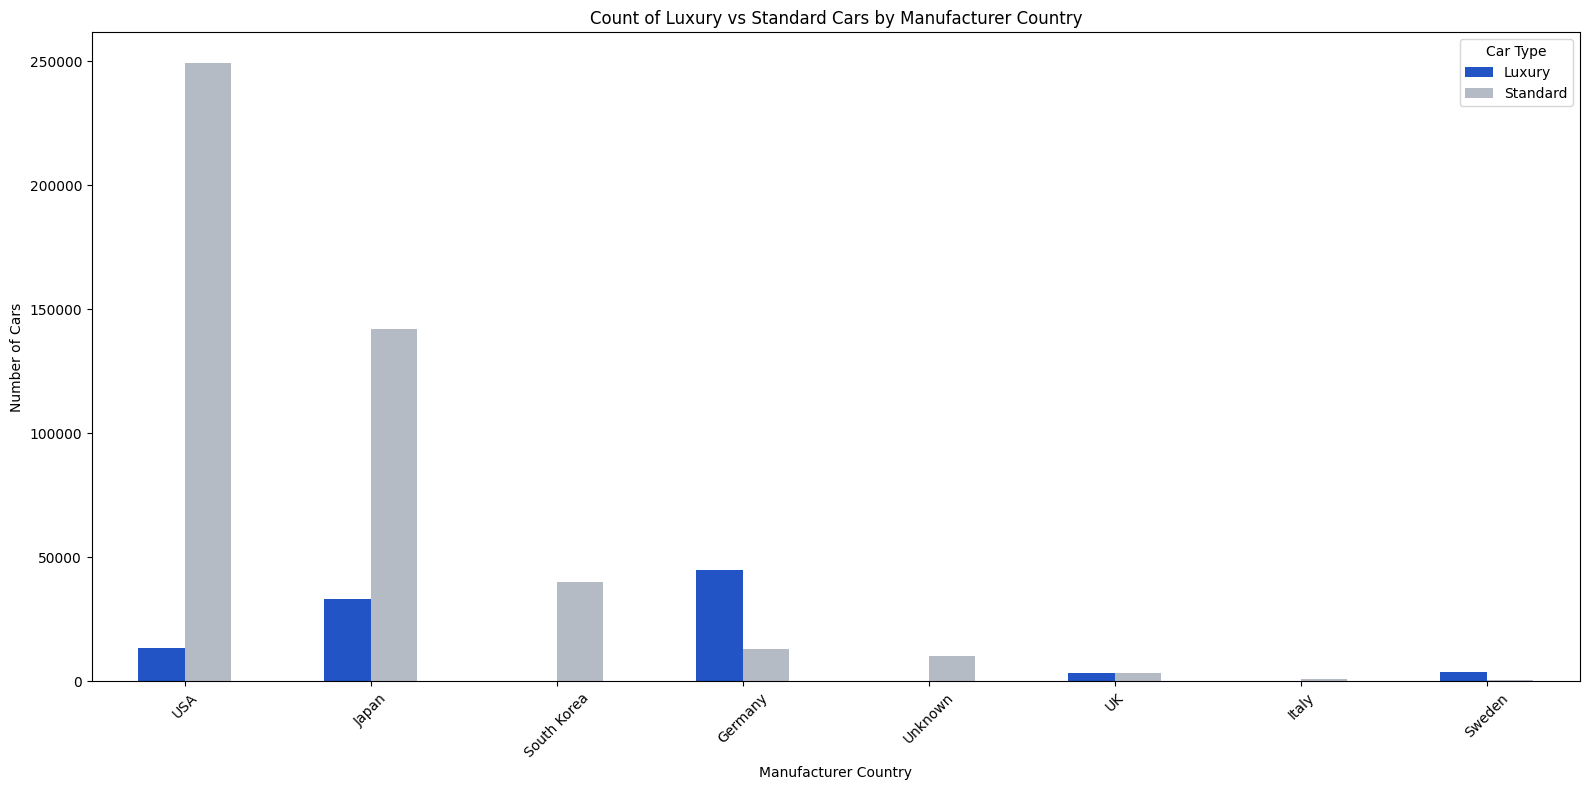

In [13]:
#% Luxury by Manufactury vs % Non Luxury
luxury_distribution = cars_data.groupby(['manufacturer_country'])['luxury_or_standard'].value_counts().unstack()\
.sort_values(by='Standard', ascending=False)

luxury_distribution.plot(kind='bar', figsize=(16,8))

plt.title('Count of Luxury vs Standard Cars by Manufacturer Country')
plt.xlabel('Manufacturer Country')
plt.ylabel('Number of Cars')
plt.xticks(rotation=45)
plt.legend(title='Car Type')
plt.tight_layout()
plt.show()

Ok. Not many luxury resales.

Maybe we should focus on only standard market for US manufacturers.

Text(0, 0.5, '')

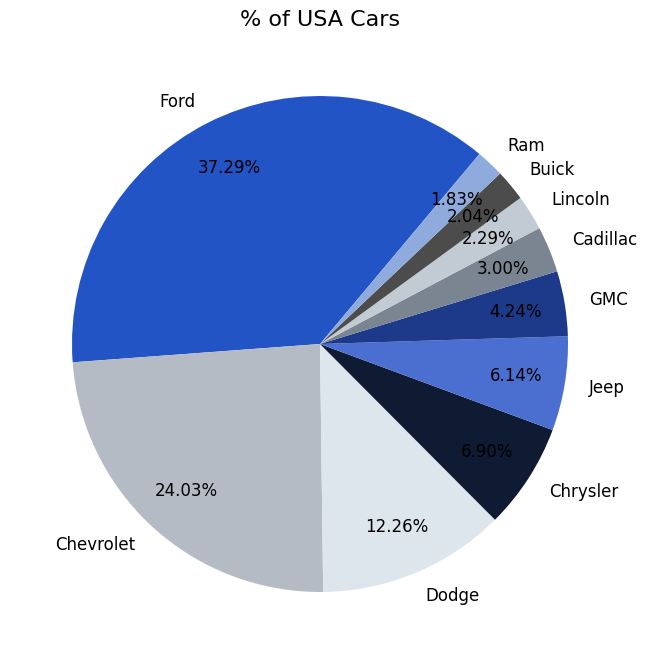

In [14]:
f, ax = plt.subplots(1,1, figsize=(8,16))

cars_data[cars_data['manufacturer_country'] == 'USA']['make'].value_counts()[:10].plot.pie(autopct='%1.2f%%', 
                                                 pctdistance=0.8, labeldistance=1.1,
                                                 fontsize=12, startangle=50)

plt.title('% of USA Cars', fontsize=16)
plt.ylabel('', fontsize=16)

<Axes: xlabel='manufacturer_country'>

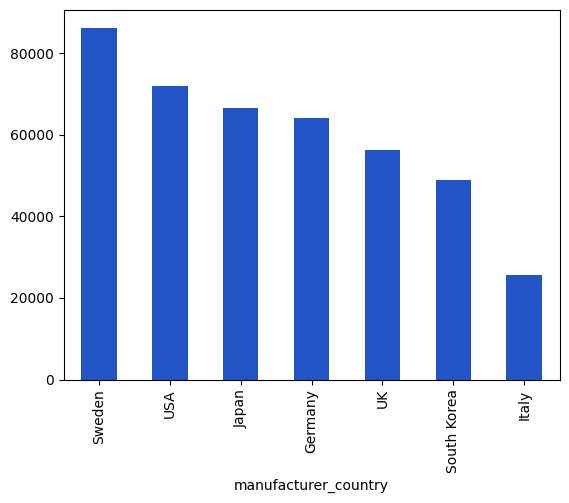

In [15]:
odometer_means = cars_data.groupby(['manufacturer_country'])['odometer'].mean()

odometer_means = odometer_means.drop(index='Unknown').sort_values(ascending=False)

odometer_means.plot(kind='bar')

USA cars tend to be resold with high mileage.

<Axes: xlabel='sellingprice', ylabel='Count'>

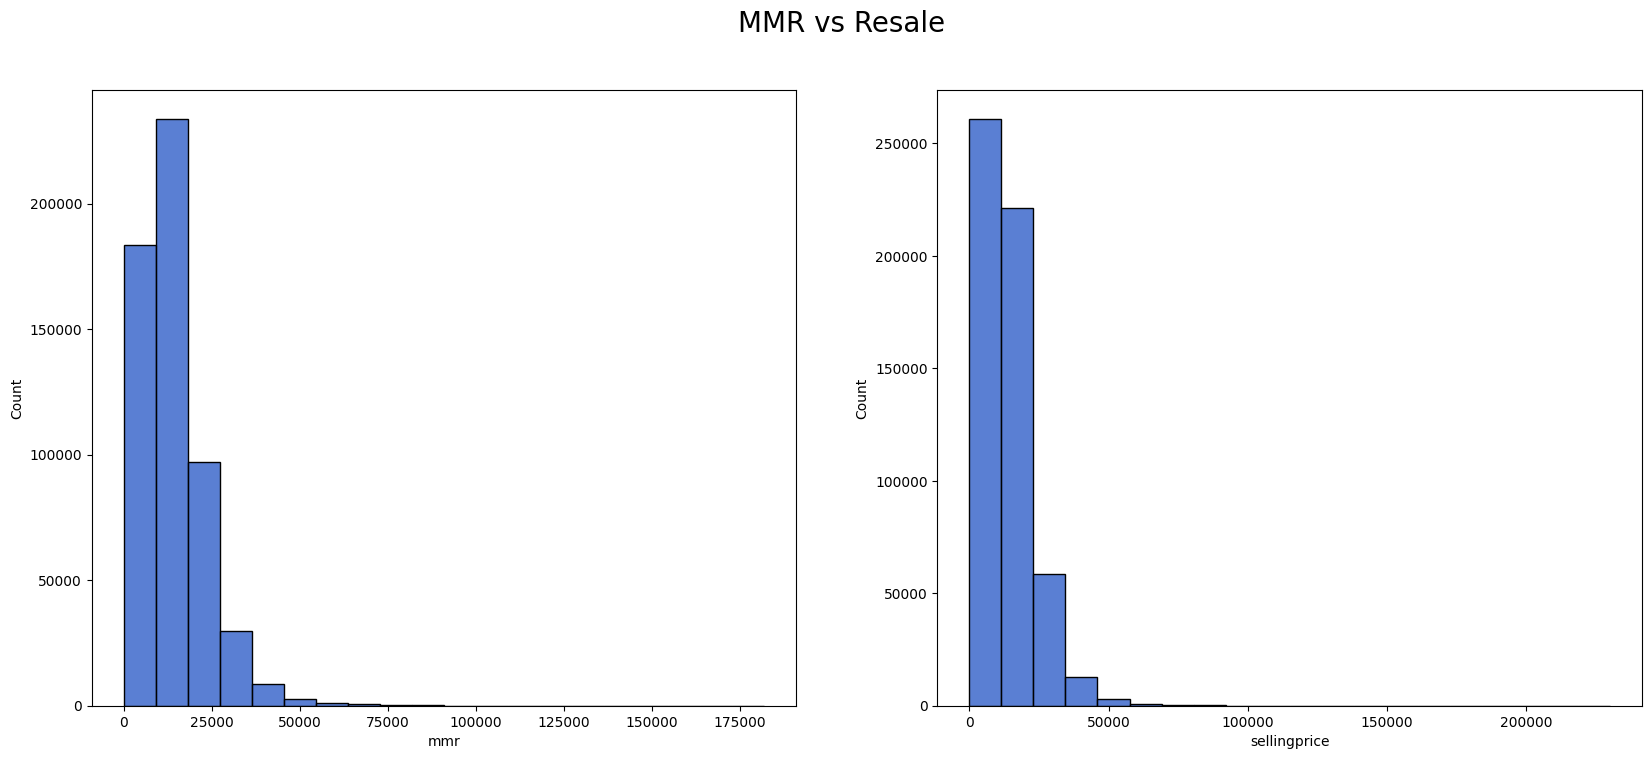

In [16]:
#Histogram MMR vs Resell Price
f, ax = plt.subplots(1,2, figsize=(20,8))

plt.suptitle('MMR vs Resale', fontsize=20)

sns.histplot(data=cars_data['mmr'], bins= 20, ax=ax[0])

sns.histplot(data=cars_data['sellingprice'], bins=20, ax=ax[1])

Text(0, 0.5, '')

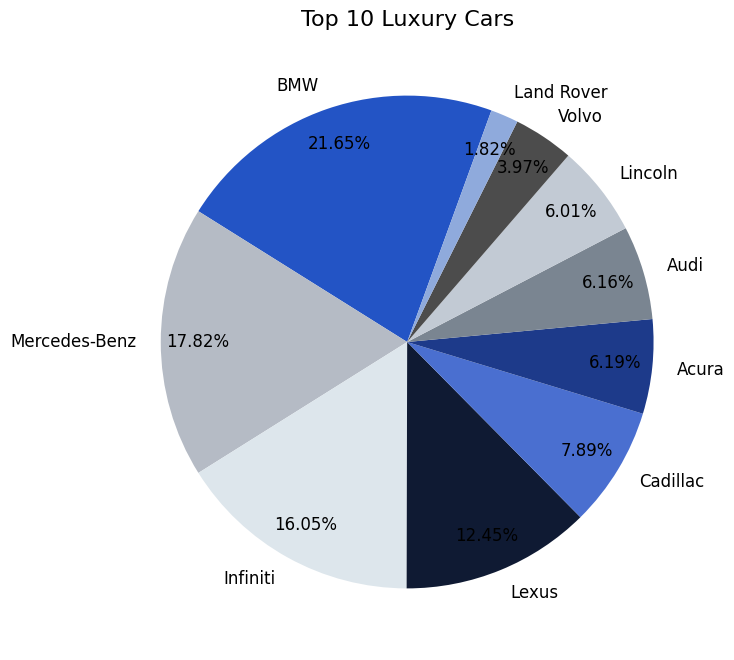

In [17]:
#Top 10 Luxury Cars
f, ax = plt.subplots(1,1, figsize=(20,8))

cars_data[cars_data['luxury_or_standard'] == 'Luxury']['make'].value_counts()[:10].plot.pie(autopct='%1.2f%%', 
                                                 pctdistance=0.85, labeldistance=1.1,
                                                 fontsize=12, startangle=70)

plt.title('Top 10 Luxury Cars', fontsize=16)
plt.ylabel('')

C:\Users\javed\AppData\Local\Temp\ipykernel_22820\2592736224.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cars_data[cars_data['luxury_or_standard'] == 'Luxury'][cars_data['manufacturer_country'] == 'USA']['make'].value_counts()


Text(0.5, 1.0, 'Top USA Luxury Cars')

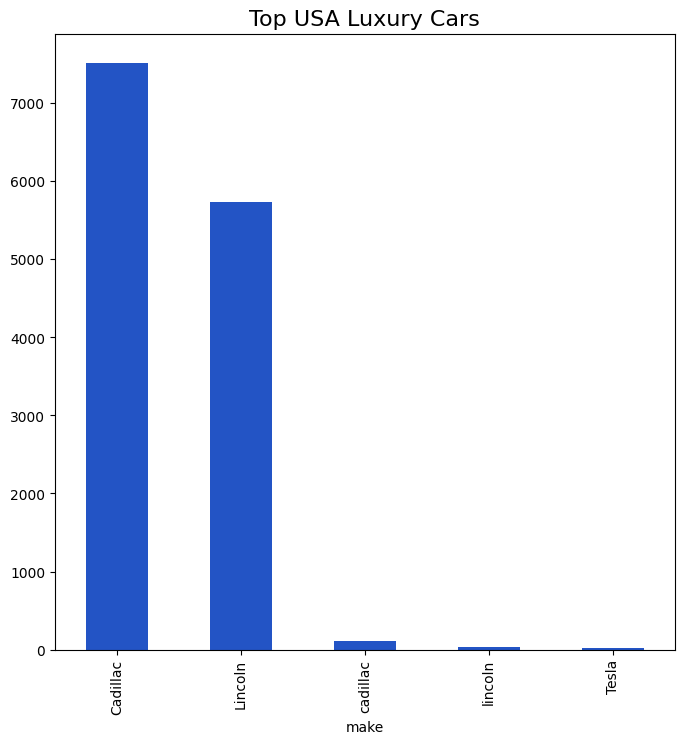

In [65]:
#Top USA Luxury Cars
f, ax = plt.subplots(1,1, figsize=(8,8))

usa_luxury = \
cars_data[cars_data['luxury_or_standard'] == 'Luxury'][cars_data['manufacturer_country'] == 'USA']['make'].value_counts()

usa_luxury.plot(kind='bar')

plt.title('Top USA Luxury Cars', fontsize=16)

Model should be estimated price of the car (with categorical variables for country)

Gap between MMR and Selling Price (potential upside)

In [19]:
cars_data

,year,make,model,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice,manufacturer_country,luxury_or_standard
0,2015,Kia,Sorento,SUV,automatic,ca,5.0,16639.0,white,black,20500.0,21500.0,South Korea,Standard
1,2015,Kia,Sorento,SUV,automatic,ca,5.0,9393.0,white,beige,20800.0,21500.0,South Korea,Standard
2,2014,BMW,3 Series,Sedan,automatic,ca,45.0,1331.0,gray,black,31900.0,30000.0,Germany,Luxury
3,2015,Volvo,S60,Sedan,automatic,ca,41.0,14282.0,white,black,27500.0,27750.0,Sweden,Luxury
4,2014,BMW,6 Series Gran Coupe,Sedan,automatic,ca,43.0,2641.0,gray,black,66000.0,67000.0,Germany,Luxury
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558057,2015,Kia,K900,Sedan,NaN,in,45.0,18255.0,silver,black,35300.0,33000.0,South Korea,Standard
558058,2012,Ram,2500,Crew Cab,automatic,wa,5.0,54393.0,white,black,30200.0,30800.0,USA,Standard
558059,2012,BMW,X5,SUV,automatic,ca,48.0,50561.0,black,black,29800.0,34000.0,Germany,Luxury
558060,2015,Nissan,Altima,sedan,automatic,ga,38.0,16658.0,white,black,15100.0,11100.0,Japan,Standard


<Axes: xlabel='make,odometer_bins'>

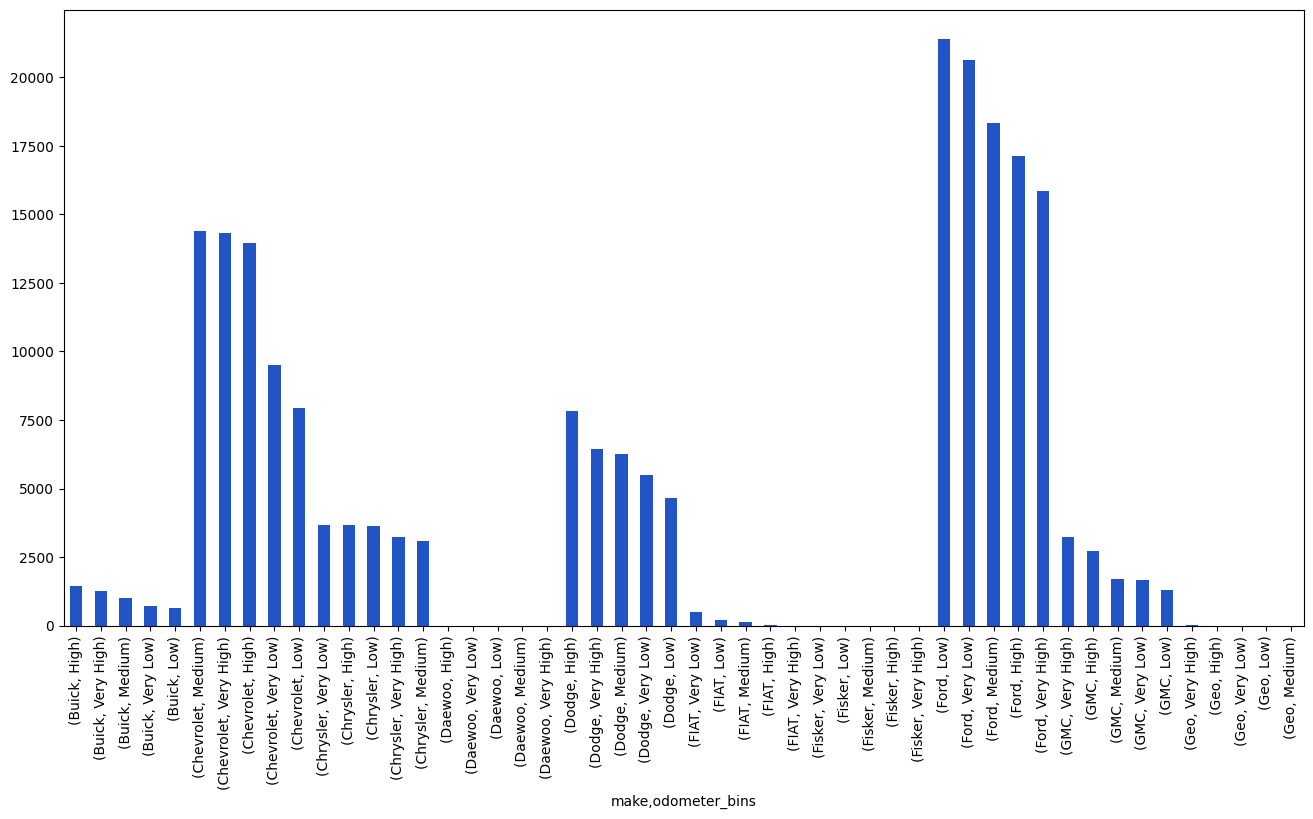

In [47]:
f, ax = plt.subplots(1,1, figsize=(16,8))

cars_data['odometer_bins'] = pd.qcut(cars_data['odometer'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
cars_data[cars_data['luxury_or_standard'] == 'Standard'].groupby('make')['odometer_bins'].value_counts()[:50].plot(kind='bar')

C:\Users\javed\AppData\Local\Temp\ipykernel_22820\2018547516.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cars_data[cars_data['luxury_or_standard'] == 'Luxury'][cars_data['manufacturer_country'] == 'USA'][['make','condition']].hist()


array([[<Axes: title={'center': 'condition'}>]], dtype=object)

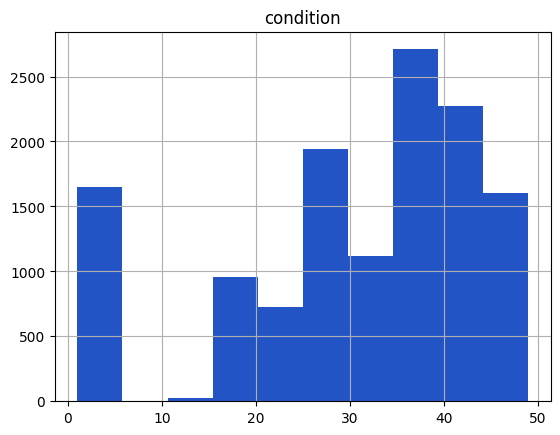

In [21]:
cars_data[cars_data['luxury_or_standard'] == 'Luxury'][cars_data['manufacturer_country'] == 'USA'][['make','condition']].hist()

In [31]:
cars_data.columns.values

array(['year', 'make', 'model', 'body', 'transmission', 'state',
       'condition', 'odometer', 'color', 'interior', 'mmr',
       'sellingprice', 'manufacturer_country', 'luxury_or_standard',
       'odometer_bins'], dtype=object)

In [56]:
y, X = dmatrices('sellingprice ~ year + odometer + condition + manufacturer_country + luxury_or_standard', data=cars_data, return_type='dataframe')

model = sm.OLS(y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           sellingprice   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                 5.313e+04
Date:                Sat, 09 Aug 2025   Prob (F-statistic):               0.00
Time:                        17:44:03   Log-Likelihood:            -5.5930e+06
No. Observations:              546325   AIC:                         1.119e+07
Df Residuals:                  546313   BIC:                         1.119e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [57]:
result.params

Intercept                             -1.942829e+06
manufacturer_country[T.Italy]         -8.135500e+02
manufacturer_country[T.Japan]         -1.658433e+03
manufacturer_country[T.South Korea]   -4.302934e+03
manufacturer_country[T.Sweden]        -6.551545e+03
manufacturer_country[T.UK]             3.445192e+03
manufacturer_country[T.USA]            6.623721e-01
manufacturer_country[T.Unknown]        2.312220e+03
luxury_or_standard[T.Standard]        -8.144920e+03
year                                   9.775831e+02
odometer                              -4.627343e-02
condition                              6.909789e+01
dtype: float64

In [58]:
result.pvalues

Intercept                               0.000000e+00
manufacturer_country[T.Italy]           1.560527e-04
manufacturer_country[T.Japan]           0.000000e+00
manufacturer_country[T.South Korea]     0.000000e+00
manufacturer_country[T.Sweden]          0.000000e+00
manufacturer_country[T.UK]              0.000000e+00
manufacturer_country[T.USA]             9.861917e-01
manufacturer_country[T.Unknown]        3.288157e-198
luxury_or_standard[T.Standard]          0.000000e+00
year                                    0.000000e+00
odometer                                0.000000e+00
condition                               0.000000e+00
dtype: float64